In [36]:
# import all packages
# import necessary libraries
import numpy as np
import pandas as pd

import matplotlib as mpl


from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn

In [37]:
# define functions
def load_data():
# set the working directory
    import os
    #os.getcwd() # this is to check the current working directory
    #os.chdir("D://EPAT//09 FP//")
    all_contracts = pd.read_csv('PriceData_bk.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted_tmp.csv',index_col='id',parse_dates=False)
    
    return all_contracts,p_sorted


def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
 
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
 
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
 
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


###############################################################################
##### ADF TEST
###############################################################################

#Calculate the spread of each pair (Spread = Y – hedge ratio * X )

def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)
    
    cadf = ts.adfuller(df.spread)   
    return cadf[1] 


###############################################################################
##### Using Kalman Filter Regression Function to calculate *hedge ratio*
##### Calculate z-score of ‘s’, using *rolling mean* and *standard deviation* for 
##### the time period of ‘half-life’ intervals. Save this as z-score
##### Using half-life function to calculate the half-life
###############################################################################

 
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    #halflife = float(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife
    

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means    



###############################################################################################################################


###############################################################################
##### BACKTEST - *NOT YET - We need clean working data otherwise we endup with 
##### floating point conversions 😢*
###############################################################################


def backtest(s1, s2, x, y ):      
    #############################################################    
    #run regression to find hedge ratio
    #and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    ##############################################################
    halflife = half_life(df1['spread'])

    ##############################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    
        
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 2 
    exitZscore = 0
    
    #set up num units long             
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe

In [38]:
#  load Pricing test data
all_contracts, p_sorted = load_data()

In [39]:
###############################################################################
##### Original contract price data gives errors due to number formats thus we 
##### will substitute with new raw numbers big enough to avoid errors🤞 .
###############################################################################
# List contracts
all_contracts.tail(10)

,BTCUSD,ETHUSD,XRPUSD,EOSUSD,XLMUSD,LTCUSD,XMRUSD,IOTAUSD,TRXUSD,ETCUSD,...,IOTAUSD.1,TRXUSD.1,ETCUSD.1,DASHUSD.1,NEOUSD.1,ZECUSD.1,OMGUSD.1,ZRXUSD.1,BCHUSD.1,BTCEUR.1
tradeDate,,,,,,,,,,,,,,,,,,,,,
2017-06-02,2630.0,6571.0,1302.0,45410.0,143500.0,72630.0,2210.0,4068.0,6076.0,15440.0,...,5254.0,1632.0,2330.0,7769.0,943.0,12485.0,13820.0,5686.0,1957.0,9045.0
2017-06-05,2655.0,6581.0,1317.0,45250.0,142920.0,73000.0,2230.0,4116.0,6088.0,15315.0,...,5276.0,1636.0,2338.0,7674.0,955.0,12505.0,13765.0,5696.0,1972.0,8930.0
2017-06-06,2652.0,6562.0,1309.0,45150.0,142620.0,73110.0,2219.0,4150.0,6108.0,15315.0,...,5242.0,1634.0,2350.0,7661.0,961.5,12490.0,13700.0,5714.0,1966.0,8900.0
2017-06-07,2668.0,6594.0,1304.0,45020.0,142800.0,73490.0,2229.0,4169.0,6166.0,15380.0,...,5218.0,1638.0,2366.0,7696.0,968.0,12505.0,13695.0,5740.0,1975.0,8870.0
2017-06-08,2679.0,6613.0,1305.0,45070.0,141630.0,72860.0,2231.0,4158.0,6148.0,15515.0,...,5162.0,1637.0,2340.0,7675.0,972.5,12420.0,13795.0,5722.0,1960.0,8885.0
2017-06-09,2693.0,6660.0,1322.0,45750.0,141620.0,72940.0,2243.0,4123.0,6208.0,15620.0,...,5182.0,1654.0,2344.0,7740.0,963.0,12485.0,13735.0,5770.0,1981.0,8930.0
2017-06-12,2679.0,6661.0,1320.0,46340.0,142020.0,73880.0,2236.0,4077.0,6268.0,15450.0,...,5252.0,1674.0,2340.0,7889.0,961.0,12630.0,13765.0,5820.0,1997.0,9095.0
2017-06-13,2656.0,6614.0,1304.0,46070.0,143880.0,72830.0,2221.0,4045.0,6288.0,15275.0,...,5274.0,1674.0,2336.0,7817.0,960.5,12540.0,13740.0,5826.0,1991.0,9090.0
2017-06-14,2676.0,6598.0,1312.0,45800.0,145220.0,72590.0,2241.0,4043.0,6286.0,15165.0,...,5232.0,1676.0,2296.0,7708.0,954.5,12685.0,13720.0,5828.0,1984.0,8955.0


Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-17:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnec

In [29]:
p_sorted.tail(10)

,BTCUSD,XRPUSD,Pvalue
id,,,
14,EOSBTC,ETHBTC,0.033350
15,XMRUSD,IOTAUSD,0.036407
16,EOSUSD,XLMUSD,0.042057
17,ETHUSD,XRPUSD,0.042588
18,ETCUSD,DASHUSD,0.043445
19,OMGUSD,ZRXUSD,0.044489
20,BCHUSD,BTCEUR,0.046238
21,IOTAUSD,TRXUSD,0.046778
22,NEOUSD,ZECUSD,0.048415


In [30]:
# find the potential pairs for out-sample testing under the condition that sharp ratio > 0.5 and CAGR > 10.5%
list_sect = []
ret = pd.DataFrame() 
for i in np.arange(p_sorted.shape[0]):
   

    print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = p_sorted.iloc[i][1]
    s2 = p_sorted.iloc[i][0]
    
    name = s1 + "-" + s2

    x = all_contracts[s1]
    y = all_contracts[s2]
    
    
    tmp, sharpe = backtest(s1, s2, x, y) 
    if sharpe > 0.5 and tmp.values[-1] > 1.105:
        ret[name] = tmp.values
        list_sect.append((s1,s2))

The total # of testing is:  23  Current:  0


C:\Users\Muletech\anaconda3\lib\site-packages\ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Muletech\anaconda3\lib\site-packages\ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The total # of testing is:  23  Current:  1
The total # of testing is:  23  Current:  2
The total # of testing is:  23  Current:  3
The total # of testing is:  23  Current:  4
The total # of testing is:  23  Current:  5
The total # of testing is:  23  Current:  6
The total # of testing is:  23  Current:  7
The total # of testing is:  23  Current:  8
The total # of testing is:  23  Current:  9
The total # of testing is:  23  Current:  10
The total # of testing is:  23  Current:  11
The total # of testing is:  23  Current:  12
The total # of testing is:  23  Current:  13
The total # of testing is:  23  Current:  14
The total # of testing is:  23  Current:  15
The total # of testing is:  23  Current:  16
The total # of testing is:  23  Current:  17
The total # of testing is:  23  Current:  18
The total # of testing is:  23  Current:  19
The total # of testing is:  23  Current:  20
The total # of testing is:  23  Current:  21
The total # of testing is:  23  Current:  22


In [31]:
# list the potential pairs for out-sample testing
list_sect

[('LTCUSD', 'XLMUSD'),
 ('ZECUSD', 'NEOUSD'),
 ('BCHUSD', 'ZRXUSD'),
 ('BTCEUR', 'BCHUSD'),
 ('ZECUSD', 'NEOUSD'),
 ('BCHBTC', 'ETHEUR'),
 ('ETCBTC', 'ETHBTC'),
 ('ETHBTC', 'EOSBTC'),
 ('IOTAUSD', 'XMRUSD'),
 ('XLMUSD', 'EOSUSD'),
 ('ZRXUSD', 'OMGUSD'),
 ('BTCEUR', 'BCHUSD'),
 ('ZECUSD', 'NEOUSD'),
 ('LTCUSD', 'XLMUSD')]

In [32]:
# in-sample testing results
#*Liquidity of a pair....? - is it tradeable or not in a short period -> weed-out the no-tradeable assets
ret.tail(20)

,LTCUSD-XLMUSD,ZECUSD-NEOUSD,BCHUSD-ZRXUSD,BTCEUR-BCHUSD,BCHBTC-ETHEUR,ETCBTC-ETHBTC,ETHBTC-EOSBTC,IOTAUSD-XMRUSD,XLMUSD-EOSUSD,ZRXUSD-OMGUSD
522,1.134289,1.240709,1.117071,1.177093,1.149626,1.209276,1.257260,1.146497,1.146980,1.128113
523,1.134289,1.240709,1.117071,1.177093,1.149626,1.208254,1.253821,1.146497,1.146980,1.128066
524,1.134289,1.240709,1.113874,1.177093,1.149626,1.199947,1.261233,1.146497,1.146980,1.118552
525,1.134289,1.240709,1.126468,1.177093,1.149626,1.205633,1.261233,1.146497,1.146980,1.127371
526,1.134289,1.240709,1.129425,1.183766,1.149626,1.208834,1.263987,1.146497,1.146980,1.132371
527,1.134289,1.240709,1.130044,1.193795,1.149626,1.218526,1.264130,1.146497,1.146980,1.132371
528,1.134289,1.240709,1.130044,1.196005,1.149626,1.218153,1.259307,1.146497,1.146980,1.132371
529,1.134289,1.240709,1.130044,1.203079,1.149626,1.218153,1.268648,1.146497,1.146980,1.132371
530,1.134289,1.240709,1.130044,1.203079,1.149626,1.218153,1.277301,1.146497,1.146980,1.132371
531,1.134289,1.240709,1.130044,1.203079,1.149626,1.218153,1.277301,1.148686,1.146980,1.132371


#### Apply Kalman filter separately (No need because its applied as inline function to workout hedging)

In [ ]:
############################################################
# Load pricing data for a security
#start = all_contracts.index.min()
#end = all_contracts.index.max()

#x = get_pricing('LMT', fields='price', start_date=start, end_date=end)
x = state_means(all_contracts)


############################################################


# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

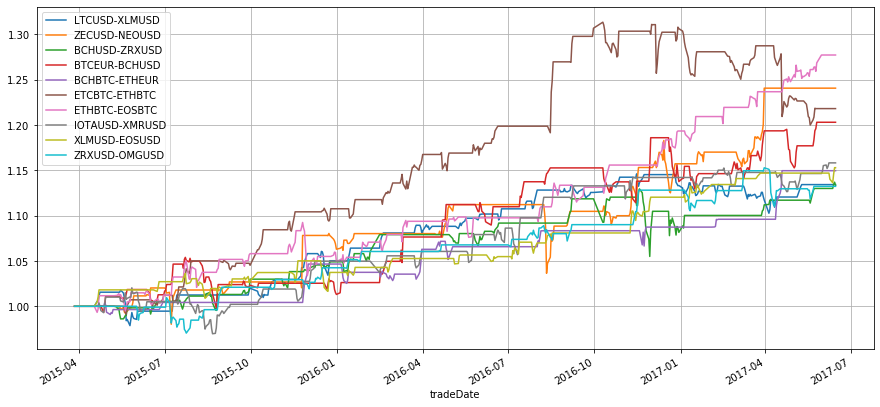

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.


In [40]:
# show the results of in sample testing
%matplotlib inline
ret.iloc[0] = 1
ret.index = all_contracts.index
ret.plot(figsize=(15,7),grid=True)

In [35]:
# calculate the performance
perf = ret.calc_stats() 
perf.display()
perf.to_csv(sep=',',path="train_perfer.csv")

Stat                 LTCUSD-XLMUSD    ZECUSD-NEOUSD    BCHUSD-ZRXUSD    BTCEUR-BCHUSD    BCHBTC-ETHEUR    ETCBTC-ETHBTC    ETHBTC-EOSBTC    IOTAUSD-XMRUSD    XLMUSD-EOSUSD    ZRXUSD-OMGUSD
-------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ----------------  ---------------  ---------------
Start                2015-03-27       2015-03-27       2015-03-27       2015-03-27       2015-03-27       2015-03-27       2015-03-27       2015-03-27        2015-03-27       2015-03-27
End                  2017-06-15       2017-06-15       2017-06-15       2017-06-15       2017-06-15       2017-06-15       2017-06-15       2017-06-15        2017-06-15       2017-06-15
Risk-free rate       0.00%            0.00%            0.00%            0.00%            0.00%            0.00%            0.00%            0.00%             0.00%            0.00%

Total Return         13.43%           24.07%           13.35%     

Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\a

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-14:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


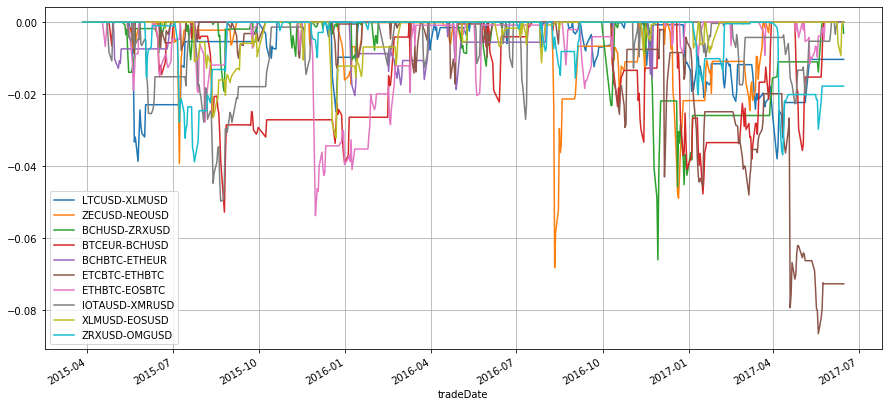

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink


In [41]:
# plot the maxinum drawndown of each pair
ffn.to_drawdown_series(ret).plot(figsize=(15,7),grid=True)  


C:\Users\Muletech\anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


start                    2015-03-27 00:00:00
end                      2017-06-15 00:00:00
rf                                         0
total_return                        0.180023
cagr                               0.0774009
max_drawdown                      -0.0134802
calmar                                5.7418
mtd                               0.00179837
three_month                        0.0202315
six_month                            0.02148
ytd                                0.0272219
one_year                           0.0776435
three_year                         0.0774009
five_year                                NaN
ten_year                                 NaN
incep                              0.0774009
daily_sharpe                         3.80521
daily_sortino                        7.66099
daily_mean                         0.0773242
daily_vol                          0.0203206
daily_skew                          0.483913
daily_kurt                           3.73194
best_day  

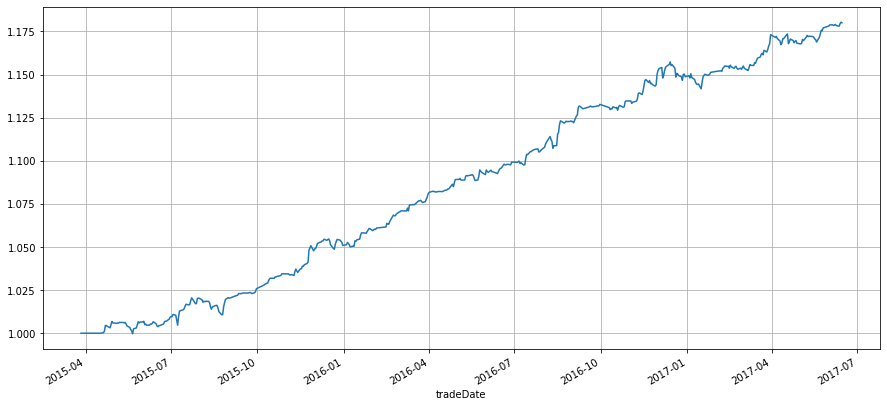

Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnec

Exception in thread Thread-20:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-23:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnec

Exception in thread Thread-26:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-29:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-32:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


Exception in thread Thread-35:
Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anvil\_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Internal server error: c63c51862d1a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Muletech\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Muletech\anaconda3\lib\site-packages\anv

In [42]:
# In sample back testing of portfolio

port = ret.mean(axis=1)
port.plot(figsize=(15,7),grid=True)

perf = port.calc_stats() 

perf.stats



In [ ]:
# In sample back testing of portfolio maxinum drawndown
ffn.to_drawdown_series(port).plot(figsize=(15,7),grid=True) 

PHASE TWO - BACKTESTING

In [ ]:
##　SAMPLE BACKＴＥＳＩＮＧ

testing_data = pd.read_csv('testing data.csv',index_col='tradeDate',parse_dates=True)

test_ret = pd.DataFrame()
for i in np.arange(len(list_sect)):
    

    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = list_sect[i][1]
    s2 = list_sect[i][0]
    
    name = s1 + "-" + s2

    x = testing_data[s1]
    y = testing_data[s2]
    
    
    test_ret[name], sharpe = backtest(s1, s2, x, y) 

In [ ]:
testing_data.tail(3)

In [ ]:
test_ret.iloc[0] = 1
test_ret.tail(3)

In [ ]:
test_ret.shape


In [ ]:
test_ret.index

In [ ]:
test_ret.plot()

In [ ]:
# Out sample back testing of portfolio

port = test_ret.mean(axis=1)
port.plot(figsize=(15,7),grid=True)

perf = port.calc_stats() 

perf.stats



In [ ]:
ffn.to_drawdown_series(port).plot(figsize=(15,7),grid=True) 

In [14]:
import anvil.server

anvil.server.connect("ZDRGUTD6AJZHT7DHDFE6H6Y3-5X7R2SBBLIDA27JA")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
